In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.10.0


# The Boston Housing Prices dataset

In [3]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

57344/57026 [==============================] - 0s 9us/step


In [4]:
print('Training set: {}'.format(train_data.shape))
print('Testing set: {}'.format(test_data.shape))

Training set: (404, 13)
Testing set: (102, 13)


In [6]:
train_data[0]

array([7.8750e-02, 4.5000e+01, 3.4400e+00, 0.0000e+00, 4.3700e-01,
       6.7820e+00, 4.1100e+01, 3.7886e+00, 5.0000e+00, 3.9800e+02,
       1.5200e+01, 3.9387e+02, 6.6800e+00])

| No. | ABBR. | MEANING |
| :--- | :----------: | :------- |
| 1 | CRIM | Per capita crime rate. |
| 2 | ZN | The proportion of residential land zoned for lots over 25,000 square feet. |
| 3 | INDUS | The proportion of non-retail business acres per town. |
| 4 | CHAS | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise). |
| 5 | NOX | Nitric oxides concentration (parts per 10 million). |
| 6 | RM | The average number of rooms per dwelling.
| 7 | AGE | The proportion of owner-occupied units built before 1940. |
| 8 | DIS | Weighted distances to five Boston employment centers. |
| 9 | RAD | Index of accessibility to radial highways. |
| 10 | TAX | Full-value property-tax rate per $10,000. |
| 11 | PTRATIO | Pupil-teacher ratio by town. |
| 12 | B | 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town. |
| 13 | LSTAT | Percentage lower status of the population. |

In [8]:
import pandas as pd

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


In [9]:
print(train_labels[0:10])

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


**Normalize features**

In [10]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


# Create the model

In [12]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    
    optimizer = tf.train.RMSPropOptimizer(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [13]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
        
EPOCHS = 500

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0,
                   callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

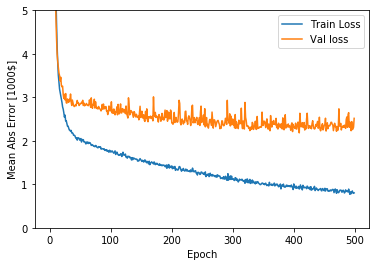

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
             label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
             label='Val loss')
    plt.legend()
    plt.ylim([0,5])
    
plot_history(history)


....................................................................................................
....................................................................................................
........................

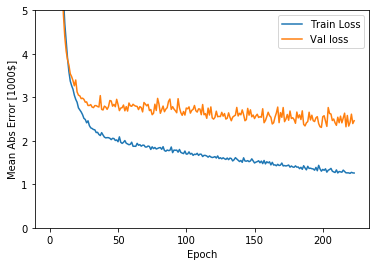

In [21]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0,
                   callbacks=[early_stop, PrintDot()])

plot_history(history)

In [23]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print('Testing set Mean Abs Error: ${:7.2f}'.format(mae * 1000))

Testing set Mean Abs Error: $2527.51


# Predict

In [24]:
test_prediction = model.predict(test_data).flatten()

print(test_prediction)

[ 9.49553   19.207281  21.824759  33.784462  25.00251   22.291775
 26.025171  22.438036  19.15856   21.641256  16.710043  16.429567
 15.481377  42.852173  20.24641   19.984533  26.693865  17.565468
 18.283981  24.820784  10.510317  11.721301  21.260767  16.07029
 18.211502  24.637304  29.349281  29.965963  11.589322  20.346497
 20.492117  15.526905  33.858105  25.285015  19.012516   7.69248
 16.088144  17.460901  17.756788  26.363089  32.29946   27.089458
 12.290882  41.389866  30.787676  26.854565  27.956045  18.438093
 21.47135   22.631742  35.727356  20.660425   9.150629  14.512786
 35.159466  27.554857  10.439506  48.345535  34.56228   24.74642
 23.849028  14.494914  14.9993105 19.534845  23.20278   20.204565
 14.208182  22.41928   11.239945   6.6530137 23.220585  30.01468
 25.11764   11.866427  25.95788   18.446064  19.519327  24.05397
 35.776188   8.934547  21.177584  37.65581   15.949458  12.4524355
 17.523207  17.931067  19.874712  20.013742  21.148424  32.141712
 21.742006  16